# Task 2: Generate Perturbed Embeddings for Full Dataset

This notebook generates embeddings for perturbed ALS cases using the full workflow.

## Overview

Due to computational constraints (GPU memory and time), we:
1. Sample 1,000 cells balanced across conditions and cell types
2. Generate unperturbed embeddings for the sample
3. Define perturbations based on gene expression differences between ALS and controls
4. Generate perturbed embeddings for each perturbation
5. Save all embeddings for downstream analysis

## Key Constraints
- **GPU Memory**: 16 GB limits batch size to 24 samples
- **Processing Time**: ~6 seconds per batch → full dataset would take ~8 hours
- **Solution**: Sample 1,000 cells (500 ALS, 500 controls) balanced across cell types

In [ ]:
# Import required libraries
import os
import anndata as ad
import numpy as np
from helical.models.geneformer import Geneformer, GeneformerConfig

# Load the full dataset containing ALS cases and healthy controls
adata = ad.read_h5ad("data/counts_combined_filtered_BA4_sALS_PN.h5ad")

# Initialize Geneformer v2 model for embedding generation
model_config = GeneformerConfig(
    model_name="gf-12L-104M-i4096",  # Geneformer v2: 12 layers, 104M parameters
    batch_size=24,                    # Maximum batch size for 16GB GPU
    device="cuda:0"                   # Use first CUDA GPU
)
geneformer_v2 = Geneformer(model_config)

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.
INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-104M-i4096' model is in 'eval' mode, on device 'cuda:0' with embedding mode 'cell'.


## Step 1: Create Balanced Sample

Sample 1,000 cells with equal representation across:
- **Conditions**: ALS cases vs. healthy controls (PN)
- **Cell Types**: All cell types represented proportionally

This ensures our analysis is not biased by cell type or condition distribution.

I have determined empirically that the maximum batch size my GPU (16 Gb) takes is 24 samples, generating embeddings takes ~6 seconds per batch.
With 112,014 samples, embedding the whole dataset would take almost 8 hours, which is not feasible, given that we also need to test multiple perturbations. Hence, we need to reduce dimensionality. For this we are going to sample 1000 cells with an equal number of case and control cells from each cell type.

In [ ]:
# Define sampling parameters
n_samples = 1000
condition_col = "Condition"  # "ALS" for cases, "PN" for controls
celltype_col = "CellType"

# Check if sample already exists to avoid resampling
if not os.path.exists("data/sample_1000_cells_balanced.h5ad"):
    # Get unique conditions and cell types
    conditions = adata.obs[condition_col].unique()
    cell_types = adata.obs[celltype_col].unique()
    
    # Sample equally from each (cell_type, condition) combination
    # This ensures balanced representation across both dimensions
    samples_per_group = n_samples // (len(conditions) * len(cell_types))
    
    sampled_obs = adata.obs.groupby([celltype_col, condition_col]).apply(
        lambda x: x.sample(n=samples_per_group, random_state=42)
    ).reset_index(level=["CellType", "Condition"], drop=True)
    
    # Extract the sampled cells from the full dataset
    sampled_adata = adata[sampled_obs.index].copy()
    
    # Save the balanced sample for future use
    sampled_adata.write_h5ad("data/sample_1000_cells_balanced.h5ad")
else:
    # Load pre-existing sample
    sampled_adata = ad.read_h5ad("data/sample_1000_cells_balanced.h5ad")

# Verify balanced sampling
print(f"Cell types distribution in the sampled data:\n{sampled_adata.obs[celltype_col].value_counts()}")
print(f"\nConditions distribution in the sampled data:\n{sampled_adata.obs[condition_col].value_counts()}")

Cell types distribution in the sampled data:
CellType
5HT3aR     52
L6         52
SOM        52
Rosehip    52
PV         52
Oligo      52
OPC        52
Mural      52
Micro      52
L5_L6      52
Astro      52
L5         52
L4_L6      52
L4_L5      52
L3_L5      52
L2_L3      52
Fibro      52
Endo       52
T_Cell     52
Name: count, dtype: int64
Conditions distribution in the sampled data:
Condition
ALS    494
PN     494
Name: count, dtype: int64


## Step 2: Compare Embeddings vs Raw Expression

Visualize both raw expression and embeddings using UMAP to understand how the foundation model transforms the data.

In [ ]:
# UMAP visualization: raw expression vs embeddings
import scanpy as sc

# Keep a copy for embedding generation (unnormalized)
sampled_adata_toemb = sampled_adata.copy()

# Process raw expression for UMAP (standard Scanpy workflow)
# 1. Normalize total counts per cell to 10,000
sc.pp.normalize_total(sampled_adata, target_sum=1e4)

# 2. Log-transform the data
sc.pp.log1p(sampled_adata)

# 3. Select highly variable genes
sc.pp.highly_variable_genes(sampled_adata, n_top_genes=2000, subset=True)

# 4. Scale to unit variance
sc.pp.scale(sampled_adata, max_value=10)

# 5. Compute PCA
sc.tl.pca(sampled_adata, svd_solver='arpack')

# 6. Compute neighborhood graph
sc.pp.neighbors(sampled_adata, n_neighbors=10, n_pcs=40)

# 7. Compute UMAP embedding
sc.tl.umap(sampled_adata)

  warnings.warn(problem)

  return dispatch(args[0].__class__)(*args, **kw)

  warnings.warn(



INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/dmitry/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/dmitry/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/dmitry/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 988 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'data_merge_id', 'data_sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Cellstates_LV

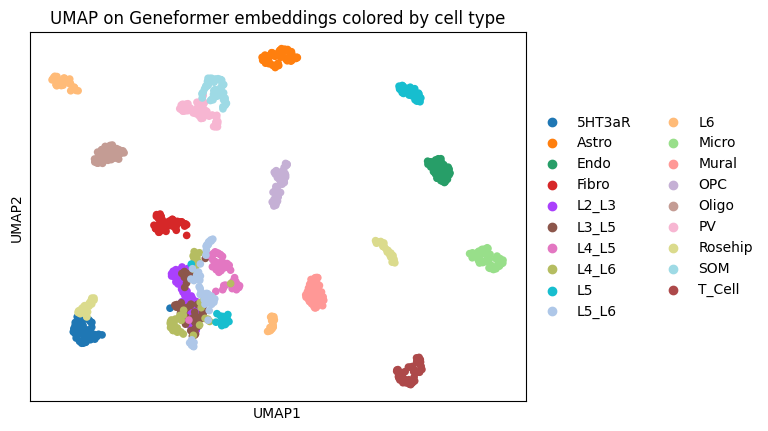

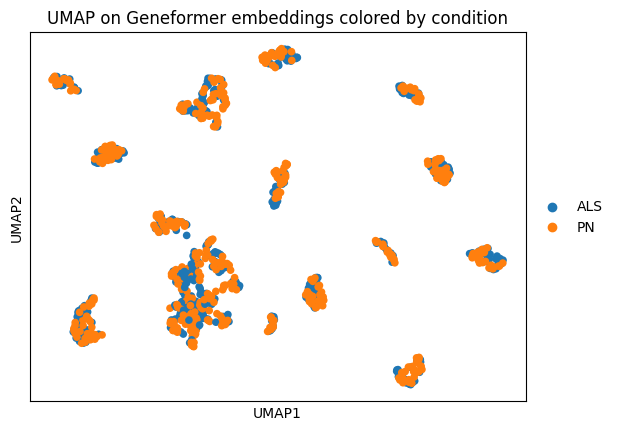

In [ ]:
# Generate embeddings using Geneformer on unnormalized counts
# Foundation models expect raw count data
embeddings = geneformer_v2.get_embeddings(geneformer_v2.process_data(sampled_adata_toemb))

# Save unperturbed embeddings for baseline comparison
np.savez_compressed("data/unperturbed_embeddings.npz", embeddings=embeddings)

# Save metadata separately for later use
sampled_adata_toemb.obs.to_csv("data/sample_1000_cells_balanced_obs.csv")

# Store embeddings in AnnData object
sampled_adata_toemb.obsm['X_helical'] = embeddings

# Compute UMAP on Geneformer embeddings
sc.pp.neighbors(sampled_adata_toemb, use_rep='X_helical', n_neighbors=10)
sc.tl.umap(sampled_adata_toemb)

# Visualize embeddings colored by cell type and condition
sc.pl.umap(sampled_adata_toemb, color=celltype_col, wspace=0.4, 
           title="UMAP on Geneformer embeddings colored by cell type")
sc.pl.umap(sampled_adata_toemb, color=condition_col, wspace=0.4, 
           title="UMAP on Geneformer embeddings colored by condition")

# Save the AnnData with embeddings
sampled_adata_toemb.write_h5ad("data/sample_1000_cells_balanced_with_embeddings.h5ad")

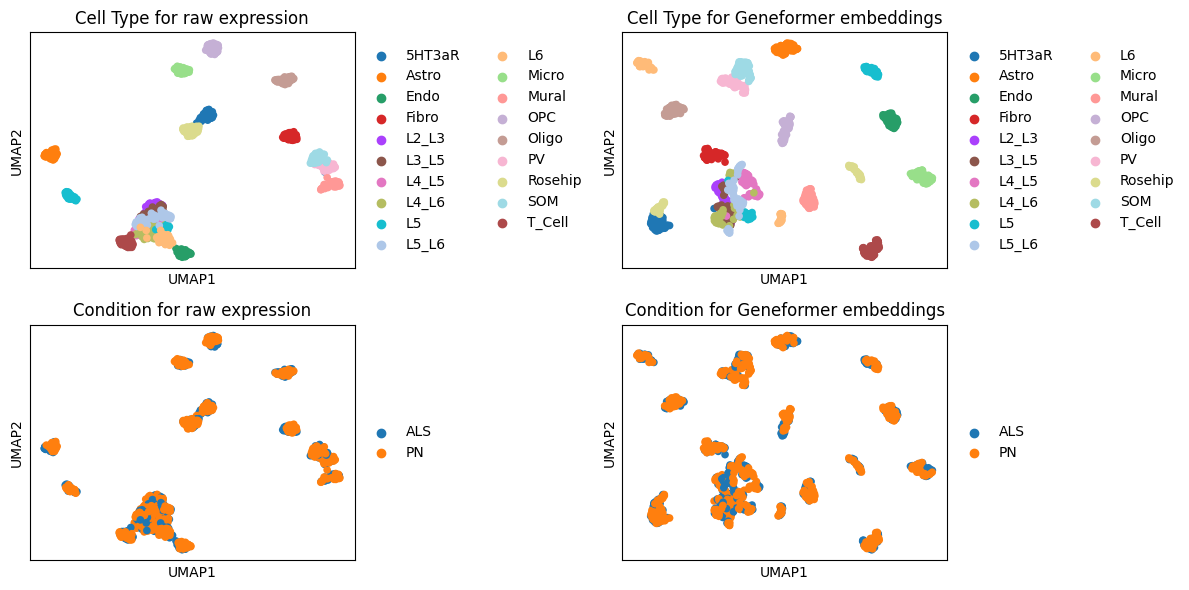

In [ ]:
# Compare raw expression UMAP vs embedding UMAP side-by-side
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Top row: Cell type coloring
sc.pl.umap(sampled_adata, color=celltype_col, ax=axs[0, 0], show=False, 
           title="Cell Type for raw expression")
sc.pl.umap(sampled_adata_toemb, color=celltype_col, ax=axs[0, 1], show=False, 
           title="Cell Type for Geneformer embeddings")

# Bottom row: Condition coloring
sc.pl.umap(sampled_adata, color=condition_col, ax=axs[1, 0], show=False, 
           title="Condition for raw expression")
sc.pl.umap(sampled_adata_toemb, color=condition_col, ax=axs[1, 1], show=False, 
           title="Condition for Geneformer embeddings")

plt.tight_layout()
plt.show()

**Observation**: With a small number of samples, UMAPing the latent space (embeddings) rather than normalized expression provides better cell type separation. The foundation model learns biologically meaningful representations.

## Step 3: Design Perturbations

Define perturbations for ALS-related genes based on their differential expression:
1. **SOD1, FUS, TARDBP, C9orf72**: ALS-causing genes - normalize to control levels + add knockouts
2. **GDNF**: Only knock up

For each gene, we:
- Calculate the fold change between ALS cases and controls
- Apply the inverse fold change to normalize ALS cells toward control expression
- For ALS genes, also create knockout (fold_change=0) conditions

In [ ]:
# Define genes to perturb (all present in the dataset)
genes_to_perturb = ["SOD1", "FUS", "TARDBP", "C9orf72", "GDNF"]
print(f"Genes to perturb (found in the data): {genes_to_perturb}")

# Calculate fold changes and design perturbations
perturbations = []

for gene in genes_to_perturb:
    # Extract gene expression for cases and controls
    gene_idx = sampled_adata_toemb.var_names.get_loc(gene)
    mean_case = np.mean(
        sampled_adata_toemb[sampled_adata_toemb.obs[condition_col] == "ALS"].X[:, gene_idx].toarray()
    )
    mean_control = np.mean(
        sampled_adata_toemb[sampled_adata_toemb.obs[condition_col] == "PN"].X[:, gene_idx].toarray()
    )
    
    # Calculate observed fold change (case / control)
    fold_change = mean_case / (mean_control + 1e-6)  # Add epsilon to avoid division by zero
    
    # Calculate perturbation fold change (inverse to normalize toward controls)
    perturbation_fold_change = 1.0 / fold_change
    
    print(f"Gene: {gene}")
    print(f"  Mean case: {mean_case:.4f}, Mean control: {mean_control:.4f}")
    print(f"  Fold change (case/control): {fold_change:.4f}")
    print(f"  Perturbation fold change (to apply to cases): {perturbation_fold_change:.4f}")
    
    # Add normalization perturbation
    perturbations.append({
        "gene_name": gene,
        "fold_change": perturbation_fold_change,
        "helical_model": geneformer_v2,
        "save_path": f"data/perturbed_embeddings_{gene}.npz"
    })
    
    # For non-GDNF genes, also add knockout perturbation
    if gene != "GDNF":
        perturbations.append({
            "gene_name": gene,
            "fold_change": 0.0,  # Complete knockout
            "helical_model": geneformer_v2,
            "save_path": f"data/perturbed_embeddings_{gene}_ko.npz"
        })

print(f"\nTotal perturbations to run: {len(perturbations)}")

Genes to perturb (found in the data): ['SOD1', 'FUS', 'TARDBP', 'C9orf72', 'GDNF']
Gene: SOD1, Mean case: 0.9555, Mean control: 1.1498, Fold change (case/control): 0.8310, Perturbation fold change (to apply to cases): 1.2034
Gene: FUS, Mean case: 0.8704, Mean control: 1.1660, Fold change (case/control): 0.7465, Perturbation fold change (to apply to cases): 1.3395
Gene: TARDBP, Mean case: 0.3968, Mean control: 0.4899, Fold change (case/control): 0.8099, Perturbation fold change (to apply to cases): 1.2347
Gene: C9orf72, Mean case: 0.6822, Mean control: 0.8259, Fold change (case/control): 0.8260, Perturbation fold change (to apply to cases): 1.2107
Gene: GDNF, Mean case: 0.0020, Mean control: 0.0223, Fold change (case/control): 0.0909, Perturbation fold change (to apply to cases): 11.0005


## Step 4: Run Perturbations

Apply all perturbations to ALS cases only (controls remain unchanged).
Each perturbation generates embeddings that will be compared against unperturbed embeddings.

In [ ]:
# Run perturbations on ALS cases only
from perturbation_workflow import PerturbationWorkflow

# Select only ALS cases for perturbation
sampled_adata_topert = sampled_adata_toemb[sampled_adata_toemb.obs[condition_col] == 'ALS'].copy()

print(f"Perturbing {sampled_adata_topert.shape[0]} ALS cells")
print(f"Running {len(perturbations)} perturbations...")

# Initialize workflow and run all perturbations
perturbation_workflow = PerturbationWorkflow(sampled_adata_topert)
_ = perturbation_workflow.perturb_batch(perturbations)

print("\nAll perturbations completed and embeddings saved!")

INFO:root:Perturbing gene SOD1 with fold change 1.203390877118644
INFO:root:Converting to csc format...
INFO:root:Multiplying by fold change...
INFO:root:Converting back to csr format...
INFO:root:Generating embeddings using Helical model...
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/dmitry/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/dmitry/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/dmitry/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 22830 genes to Ensembl IDs from a total of 22832 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 494 × 22832
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', '